https://finance.sina.com.cn/stock/stockzmt/2020-03-18/doc-iimxyqwa1302257.shtml

https://blog.csdn.net/qq_41648495/article/details/114380780

[合并测试](#%E5%90%88%E5%B9%B6%E4%B8%8A%E6%B6%A8%E5%B8%82%E5%92%8C%E4%B8%8B%E8%B7%8C%E5%B8%82%E7%9A%84%E4%B9%B0%E5%8D%96%E8%A7%84%E5%88%99%E5%8F%8A%E4%B9%B0%E5%8D%96%E6%89%8B%E6%B3%95)效果看上去不错（达到基准2倍）。但是[盲测](#%E7%9B%B2%E6%B5%8B)效果不佳（未能超过基准）。待后续处理。

根据[循环回测](#%E5%BE%AA%E7%8E%AF%E5%9B%9E%E6%B5%8B)发现一个有趣的现象，虽然正向收益的年份，收益率均不如基准，但是在负向收益的年份，却可以保持正向收益（这应该是因为我们区分了上涨市和下跌市的不同操作而做到的），并且所有年份中的策略最大回撤均低于基准最大回撤。

所以这种策略应该还算是一个可以备选的策略。

In [2]:
# import logging
# logging.basicConfig(level=logging.DEBUG) 

import numpy as np
import talib
import pandas as pd
from tqdm import tqdm_notebook
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import matplotlib.pyplot as plt

### 原始数据

In [3]:
CODE='510310'
START='2013-04-23'
END='2019-12-31'
INIT_CASH=10000
DEFAULT_MA=20

In [4]:
def get_data(code,start,end,ma=DEFAULT_MA):
    ori_data = QA.QA_fetch_index_day_adv(code,start=start,end=end).data.reset_index(level=1, drop=True)
    data_qfq = ori_data
    # 收盘价变化率
    data_qfq['pct'] = data_qfq['close'].pct_change()
    data_qfq['date'] = data_qfq.index.get_level_values(0)
    data_qfq['date'] = pd.to_datetime(data_qfq['date'])
    # 星期一为0，星期天为6
    data_qfq['weekday'] = data_qfq['date'].dt.weekday
    data_qfq['nextday']=data_qfq['weekday'].shift(-1)
    # 简单移动均线
    data_qfq["MA"] = QA.QA_indicator_MA(data_qfq, ma)
    data_qfq['avg_price']=(data_qfq['close']+data_qfq['open']+data_qfq['high']+data_qfq['low'])/4
    data_qfq['avg_pct'] = data_qfq['avg_price'].pct_change()
    data_qfq['up']=False
    data_qfq['down']=False
    data_qfq.loc[data_qfq['close']>data_qfq["MA"],'up']=True
    data_qfq.loc[data_qfq['close']<data_qfq["MA"],'down']=True
    data_qfq['prev_up']=data_qfq['up'].shift()
    data_qfq['prev_down']=data_qfq['down'].shift()

    data_qfq.dropna(inplace=True)
    return data_qfq

In [5]:
data_qfq=get_data(CODE,START,END)
data_qfq.head(1)

,open,close,high,low,vol,amount,date_stamp,volume,pct,date,weekday,nextday,MA,avg_price,avg_pct,up,down,prev_up,prev_down
date,,,,,,,,,,,,,,,,,,,
2013-05-23,1.014,1.006,1.022,1.005,19025.0,1.9293e+06,1.3692e+09,19025.0,-0.0128,2013-05-23,3,4.0,0.9828,1.0117,-0.0049,True,False,False,False


In [6]:
def get_desc(data,**kwargs):
    data['change']=(data['close']-data['open'])/data['close']
    pct=data.groupby('weekday')['pct'].agg(
    {'mean', 'median'}).rename(columns={
        'mean': '收盘价涨跌幅均值',
        'median': '收盘价涨跌幅中位数'
    })
    pct1=data.groupby('weekday')['avg_pct'].agg(
    {'mean', 'median'}).rename(columns={
        'mean': '日均值涨跌幅均值',
        'median': '日均值涨跌幅中位数'
    })
    pct2=data.groupby('weekday')['change'].agg(
    {'mean', 'median'}).rename(columns={
        'mean': '日收盘相对开盘涨跌幅均值',
        'median': '日收盘相对开盘涨跌幅中位数'
    })
    # 胜率
    temp1 = data.groupby('weekday')['pct'].size()
    temp2 = data[data['pct'] > 0].groupby(
    'weekday')['pct'].size()
    win_rate=(temp2 / temp1).to_frame('收盘价涨跌幅胜率').sort_values(
    '收盘价涨跌幅胜率', ascending=False)
    
    df=pct.join(win_rate).join(pct1).join(pct2).sort_index()
    df.set_index(pd.Index(['周一','周二','周三','周四','周五']),inplace=True)
    return df

def show_desc(data,info_only=True,**kwargs):
    df=get_desc(data,**kwargs)
    if not info_only:
        f = plt.figure(figsize=(15,3))
        ax1 = f.add_subplot(131)
        ax2 = f.add_subplot(132)
        ax3 = f.add_subplot(133)

        ax1.plot(df.index, df[['收盘价涨跌幅均值','收盘价涨跌幅中位数']])
        ax1.legend(['均值','中位数'])
        ax1.set_title("收盘价涨跌幅")

        ax2.plot(df.index, df[['日均值涨跌幅均值','日均值涨跌幅中位数']])
        ax2.legend(['均值','中位数'])
        ax2.set_title("日均值涨跌幅")

        ax3.plot(df.index, df[['日收盘相对开盘涨跌幅均值','日收盘相对开盘涨跌幅中位数']])
        ax3.legend(['均值','中位数'])
        ax3.set_title("日均值涨跌幅")
        
        plot_title=kwargs.pop('plot_title',"")
        f.suptitle(plot_title)
    
    return df.T.style.highlight_max(color='red', axis=1).highlight_min(
        color='green', axis=1).format("{:.2%}")

,周一,周二,周三,周四,周五
收盘价涨跌幅中位数,0.18%,0.12%,-0.10%,-0.14%,0.13%
收盘价涨跌幅均值,0.14%,0.08%,-0.04%,-0.04%,0.11%
收盘价涨跌幅胜率,56.19%,53.37%,41.77%,40.74%,53.29%
日均值涨跌幅中位数,0.08%,0.11%,0.03%,-0.04%,0.08%
日均值涨跌幅均值,0.13%,0.05%,0.03%,-0.04%,0.05%
日收盘相对开盘涨跌幅中位数,0.13%,0.13%,-0.06%,-0.12%,0.11%
日收盘相对开盘涨跌幅均值,0.08%,0.11%,0.00%,0.00%,0.11%


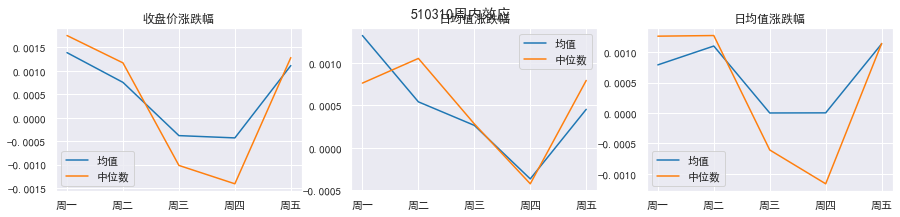

In [7]:
show_desc(data_qfq,False,plot_title='{}周内效应'.format(CODE))

In [8]:
def simple_test(data,plot=True,**kwargs):
    """
    **未考虑T+1交易的情况**
    Args:
        trade_func: 交易方法。用来在data中标记buy和sell。默认为None。
        plot_title: 绘图时的标题
    """
    dt=data.copy()
    dt['buy']=0
    dt['sell']=0
    trade_func=kwargs.pop('trade_func',None)
    trade_func_params=kwargs.pop('trade_func_params',{})
    if trade_func:
        trade_func(dt,**trade_func_params)
    dt['每日均价变更']=dt['avg_price'].pct_change()
    dt['每日开盘/收盘变更']=dt['close']/dt['open']-1
    dt['每日收盘价变更']=dt['close'].pct_change()
    # 持仓标记
    dt['hold']=dt['buy'].replace(0, np.NaN).fillna(method='ffill')
    dt.loc[(dt['hold']==1)&(dt['sell']==1),'hold']=np.NaN
    dt['hold'].fillna(0,inplace=True)
    #考虑A股T+1特性，去除前后hold均为0但当天hold为1的数据
    dt['hold_real']=dt['hold']
    dt.loc[(dt['hold_real']==1)&(dt['hold_real'].shift()==0)&(dt['hold_real'].shift(-1)==0),'hold_real']=0
    dt['策略-每日均价累加']=(dt['每日均价变更']*dt['hold']).cumsum()
    dt['策略T+1-每日均价累加']=(dt['每日均价变更']*dt['hold_real']).cumsum()
    dt['基准-每日均价累加']=(dt['每日均价变更']).cumsum()
    dt['策略-每日收盘价累加']=(dt['每日收盘价变更']*dt['hold']).cumsum()
    dt['策略T+1-每日收盘价累加']=(dt['每日收盘价变更']*dt['hold_real']).cumsum()
    dt['基准-每日收盘价累加']=(dt['每日收盘价变更']).cumsum()
    if plot:
        f = plt.figure(figsize=(15,3))
        ax1 = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        ax1.plot(dt.index,dt['策略-每日均价累加'],label='策略')
        ax1.plot(dt.index,dt['策略T+1-每日均价累加'],label='策略T+1')
        ax1.plot(dt.index,dt['基准-每日均价累加'],label='基准')
        ax1.legend()
        ax1.set_title("每日均价变更")
        ax2.plot(dt.index,dt['策略-每日收盘价累加'],label='策略')
        ax2.plot(dt.index,dt['策略T+1-每日收盘价累加'],label='策略T+1')
        ax2.plot(dt.index,dt['基准-每日收盘价累加'],label='基准')
        ax2.legend()
        ax2.set_title("每日收盘价变更")
    return dt

In [9]:
# import itertools
# def loop_test(datas,**kwargs):
#     """
#     笛卡尔积的方式对交易方式进行测算
    
#     Args:
#         trade_func: 交易方法。用来在data中标记buy和sell。默认为None。
#     """
#     product_datas=[]
#     for x in itertools.product(range(0,5),range(0,5)):
#         if x[0]==x[1]:
#             continue

#         kwargs['trade_func_params']={'x':x[0],'y':x[1]}
#         d=simple_test(datas,plot=False,**kwargs)
#         y=d[['策略-每日均价累加','策略T+1-每日均价累加','基准-每日均价累加',
#              '策略-每日收盘价累加','策略T+1-每日收盘价累加','基准-每日收盘价累加']].iloc[-1]
#         y.name=x
#         product_datas.append(y.to_frame().T)
#     cart_df=pd.concat(product_datas)
#     cart_df['差-每日均价累加']=cart_df['策略-每日均价累加']-cart_df['基准-每日均价累加']
#     cart_df['差-每日均价累加-T+1']=cart_df['策略T+1-每日均价累加']-cart_df['基准-每日均价累加']
#     cart_df['差-每日收盘价累加']=cart_df['策略-每日收盘价累加']-cart_df['基准-每日收盘价累加']
#     cart_df['差-每日收盘价累加-T+1']=cart_df['策略T+1-每日收盘价累加']-cart_df['基准-每日收盘价累加']
#     return cart_df

~~以笛卡尔积的方式测算，利用周内效应是否能够跑赢基准~~

In [10]:
# def simple_trade_func_x(data,**kwargs):
#     data.loc[data['weekday']==kwargs.pop('x',None),'buy']=1
#     data.loc[data['weekday']==kwargs.pop('y',None),'sell']=1
#     return data

# cart_df=loop_test(data_qfq,trade_func=simple_trade_func_x)
# cart_df.sort_values('差-每日均价累加',ascending=False).head()

~~结果显示：单纯以周四卖出，下一个交易日非周四时买入。只能稍稍跑赢基准而已。（尚未考虑交易成本）~~

以`收盘价涨跌幅胜率`来看，应该跳过周三和周四两天。

**买入：**

|今天|明天|买入价格|
|---|---|---|
|周一(0)|周二(1)、周五(4)|开盘价(open)|
|周二(1)|周一(0)、周五(4)|开盘价(open)|
|周三(2)|周一(0)、周二(1)、周五(4)|收盘价(close)|
|周四(3)|周一(0)、周二(1)、周五(4)|收盘价(close)|
|周五(4)|周一(0)、周二(1)|开盘价(open)|

**卖出：**

|今天|明天|卖出价格|
|---|---|---|
|周一(0)|周三(2)、周四(3)|收盘价(close)|
|周二(1)|周三(2)、周四(3)|收盘价(close)|
|周三(2)||开盘价(open)|
|周四(3)||开盘价(open)|
|周五(4)|周三(2)、周四(3)|收盘价(close)|

In [11]:
def simple_trade_func(data,**kwargs):
    data.loc[(data['weekday']==0)&(data['nextday'].isin([1,4])),'buy']=1
    data.loc[(data['weekday']==1)&(data['nextday'].isin([0,4])),'buy']=1
    data.loc[(data['weekday']==2)&(data['nextday'].isin([0,1,4])),'buy']=1
    data.loc[(data['weekday']==3)&(data['nextday'].isin([0,1,4])),'buy']=1
    data.loc[(data['weekday']==4)&(data['nextday'].isin([0,1])),'buy']=1
    
    data.loc[(data['weekday'].isin([2,3])),'sell']=1
    data.loc[(data['weekday'].isin([0,1,4]))&(data['nextday'].isin([2,3])),'sell']=1
    return data

# simple_data=simple_test(get_data(CODE,START,END),trade_func=simple_trade_func)

回归测试

实际操作过程中，稍稍跑赢基准而已。

In [12]:
def simple_buy_price_func(index, row, data):
    tom = data.iloc[data.index.get_loc(index)+1]
    if row['weekday'] in (0,1,4):
        return row['open']
    else:
        return row['close']

def simple_sell_price_func(index, row, data):
    if row['weekday'] in (0,1,4):
        return row['close']
    else:
        return row['open']

from gquant.backtest import backtest
x = get_data(CODE, START, END)
simple_trade_func(x)
m = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=simple_buy_price_func, sell_price_func=simple_sell_price_func)
m.stats()
# m.report().to_frame().T
# m.plot_cash()

1612it [00:01, 879.99it/s]


基准收益      0.8073
策略收益      0.9479
基准年化收益    0.1252
策略年化收益    0.1470
基准最大回撤   -0.4562
策略最大回撤   -0.4153
dtype: float64

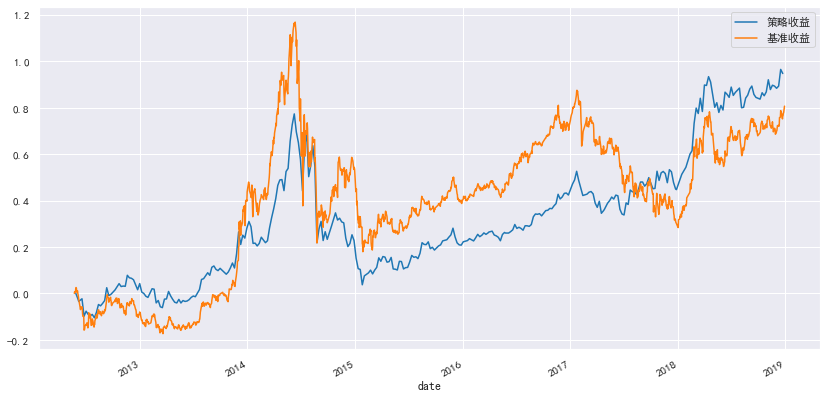

In [13]:
m.plot_cash()

下面考虑估计在上涨市（前日收盘价高于20日均线）、下跌市（前日收盘价低于20日均线）的市场中是否存在可以被利用的周内效应。

# 上涨市

In [14]:
x = get_data(CODE, START, END)
show_desc(x[x['prev_up']==True],info_only=True)

,周一,周二,周三,周四,周五
收盘价涨跌幅中位数,0.27%,0.00%,-0.10%,-0.12%,0.14%
收盘价涨跌幅均值,0.26%,-0.00%,-0.04%,0.07%,0.13%
收盘价涨跌幅胜率,59.34%,47.18%,40.80%,42.27%,54.64%
日均值涨跌幅中位数,0.23%,0.20%,0.04%,-0.00%,0.20%
日均值涨跌幅均值,0.32%,0.25%,0.09%,0.11%,0.20%
日收盘相对开盘涨跌幅中位数,0.17%,0.00%,-0.06%,-0.09%,0.11%
日收盘相对开盘涨跌幅均值,0.21%,0.04%,-0.02%,0.08%,0.10%


以`收盘价涨跌幅胜率`来看，应该只在周一和周五持有股票

**买入：**

|今天|明天|买入价格|
|---|---|---|
|周一(0)|周一(0)、周五(4)|开盘价(open)|
|周二(1)|周一(0)、周五(4)|开盘价(open)|
|周三(2)|周一(0)、周五(4)|收盘价(close)|
|周四(3)|周一(0)、周五(4)|收盘价(close)\*以中位数估算|
|周五(4)|周一(0)、周五(4)|开盘价(open)|

**卖出：**

|今天|明天|卖出价格|
|---|---|---|
|周一(0)|周二(1)、周三(2)、周四(3)|收盘价(close)|
|周二(1)|周二(1)、周三(2)、周四(3)|收盘价(close)|
|周三(2)|周二(1)、周三(2)、周四(3)|开盘价(open)|
|周四(3)|周二(1)、周三(2)、周四(3)|开盘价(open)\*以中位数估算|
|周五(4)|周二(1)、周三(2)、周四(3)|收盘价(close)|

In [15]:
def _rasing_trade_fun_buy(data,**kwargs):
    data.loc[(data['prev_up']==True)&(data['nextday'].isin([0,4])),'buy']=1
    return data

def _rasing_trade_fun_sell(data,**kwargs):
    data.loc[(data['prev_up']==True)&(data['nextday'].isin([1,2,3])),'sell']=1
    return data

def rasing_trade_func_fix(data,**kwargs):
    data=_rasing_trade_fun_buy(data,**kwargs)
    data=_rasing_trade_fun_sell(data,**kwargs)
    data.loc[data.shift()['up']!=True,'sell']=1
    return data

def rasing_buy_price_func(index, row, data):
    if row['weekday'] in (0,1,4):
        return row['open']
    else:
        return row['close']

def rasing_sell_price_func(index, row, data):
    if row['weekday'] in (0,1,4):
        return row['close']
    else:
        return row['open']

x = get_data(CODE, START, END)
rasing_trade_func_fix(x)
m = backtest(x, benchmark_pd=x[x['prev_up']==True], buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=rasing_buy_price_func, sell_price_func=rasing_sell_price_func)
m.stats()
# m.report().to_frame().T
# m.plot_cash()

1612it [00:01, 1567.08it/s]


基准收益      0.8017
策略收益      0.5367
基准年化收益    0.2099
策略年化收益    0.1405
基准最大回撤   -0.4383
策略最大回撤   -0.1824
dtype: float64

回归测试

**实际操作过程中，远远低于基准。但是可以看到回撤降低非常多。**

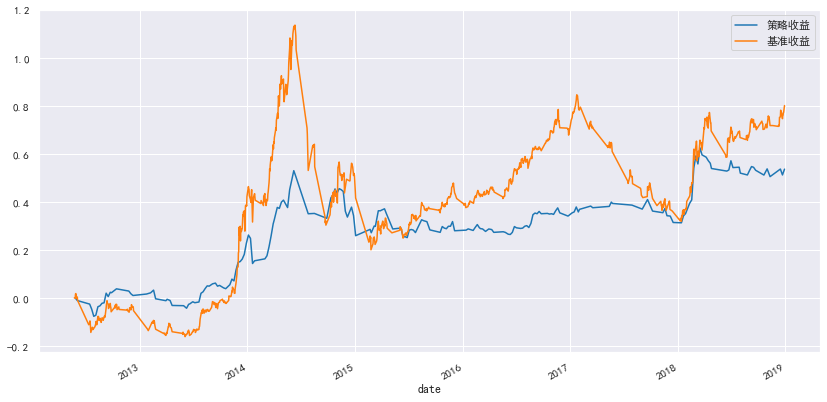

In [16]:
m.plot_cash()

# 下跌市

In [17]:
x = get_data(CODE, START, END)
show_desc(x[x['prev_down']==True],info_only=True)

,周一,周二,周三,周四,周五
收盘价涨跌幅中位数,0.11%,0.34%,-0.08%,-0.15%,0.10%
收盘价涨跌幅均值,-0.03%,0.19%,-0.03%,-0.20%,0.09%
收盘价涨跌幅胜率,51.88%,62.60%,43.31%,38.76%,51.47%
日均值涨跌幅中位数,-0.19%,-0.08%,0.00%,-0.29%,-0.12%
日均值涨跌幅均值,-0.12%,-0.24%,-0.07%,-0.26%,-0.17%
日收盘相对开盘涨跌幅中位数,0.00%,0.25%,-0.06%,-0.19%,0.13%
日收盘相对开盘涨跌幅均值,-0.10%,0.21%,0.03%,-0.12%,0.13%


以`收盘价涨跌幅胜率`来看，应该只在周一、周二和周五持有股票。*周一要不要，还有待考虑*

**买入：**

|今天|明天|买入价格|
|---|---|---|
|周一(0)|周一(0)、周二(1)、周五(4)|收盘价(close)|
|周二(1)|周一(0)、周二(1)、周五(4)|开盘价(open)|
|周三(2)|周一(0)、周二(1)、周五(4)|收盘价(close)\*以中位数估算|
|周四(3)|周一(0)、周二(1)、周五(4)|收盘价(close)|
|周五(4)|周一(0)、周二(1)、周五(4)|开盘价(open)|

**卖出：**

|今天|明天|卖出价格|
|---|---|---|
|周一(0)|周三(2)、周四(3)|开盘价(open)|
|周二(1)|周三(2)、周四(3)|收盘价(close)|
|周三(2)|周三(2)、周四(3)|开盘价(open)\*以中位数估算|
|周四(3)|周三(2)、周四(3)|开盘价(open)|
|周五(4)|周三(2)、周四(3)|收盘价(close)|

In [18]:
def _falling_trade_func_buy(data,**kwargs):
    data.loc[(data['prev_down']==True)&(data['nextday'].isin([0,1,4])),'buy']=1
    return data

def _falling_trade_func_sell(data,**kwargs):
    data.loc[(data['prev_down']==True)&(data['nextday'].isin([2,3])),'sell']=1
    return data

def falling_trade_func(data,**kwargs):
    data=_falling_trade_func_buy(data,**kwargs)
    data=_falling_trade_func_sell(data,**kwargs)
    data.loc[data.shift()['down']!=True,'sell']=1
    return data

def falling_buy_price_func(index, row, data):
    if row['weekday'] in (0,2,3):
        return row['close']
    else:
        return row['open']

def falling_sell_price_func(index, row, data):
    if row['weekday'] in (0,2,3):
        return row['open']
    else:
        return row['close']

x = get_data(CODE, START, END)
falling_trade_func(x)
m = backtest(x, benchmark_pd=x[x['prev_down']==True], buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=falling_buy_price_func, sell_price_func=falling_sell_price_func)
m.stats()

1612it [00:00, 1818.73it/s]


基准收益      0.7270
策略收益      0.3172
基准年化收益    0.2771
策略年化收益    0.1209
基准最大回撤   -0.4364
策略最大回撤   -0.2666
dtype: float64

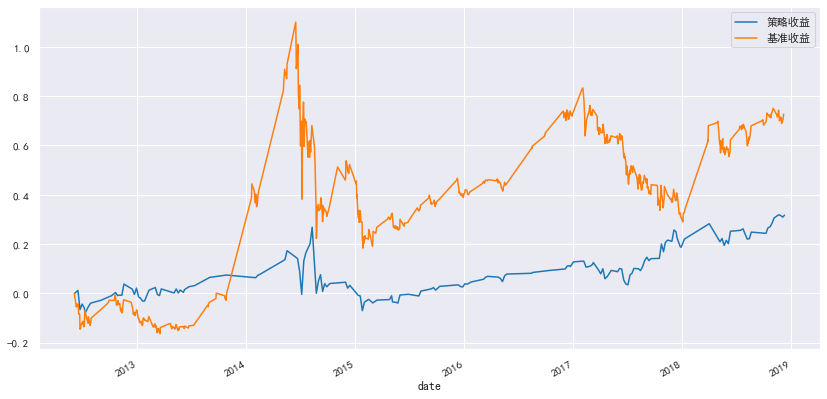

In [19]:
m.plot_cash()

---

# 合并上涨市和下跌市的买卖规则及买卖手法

In [20]:
def combine_trade_func_fix(data,**kwargs):
    data=_rasing_trade_fun_buy(data,**kwargs)
    data=_falling_trade_func_buy(data,**kwargs)
    data=_rasing_trade_fun_sell(data,**kwargs)
    data=_falling_trade_func_sell(data,**kwargs)
    return data

def combine_buy_price_func(index, row, data):
    if row['prev_up']==True:
        return rasing_buy_price_func(index,row,data)
    if row['prev_down']==True:
        return falling_buy_price_func(index,row,data)

def combine_sell_price_func(index, row, data):
    if row['prev_up']==True:
        return rasing_sell_price_func(index,row,data)
    if row['prev_down']==True:
        return falling_sell_price_func(index,row,data)


x = get_data(CODE, START, END)
x=combine_trade_func_fix(x)
m = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=combine_buy_price_func, sell_price_func=combine_sell_price_func)
m.stats()
# m.report().to_frame().T
# m.plot_cash()

1612it [00:01, 951.29it/s] 


基准收益      0.8073
策略收益      1.2326
基准年化收益    0.1252
策略年化收益    0.1912
基准最大回撤   -0.4562
策略最大回撤   -0.3523
dtype: float64

😲  奇迹出现了！！！合并了上涨市和下跌市两种条件及购买卖出操作后，竟然收益达到了基准的一倍。

In [21]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m.report())

剩余现金              22386.76
交易次数                   331
未结束交易次数                  0
未结束交易购买金额             0.00
盈利次数                   190
亏损次数                   134
盈利次数占比              57.40%
盈利(含交易费)次数             190
亏损(含交易费)次数             141
盈利(含交易费)次数占比        57.40%
盈利交易平均获利            270.67
亏损交易平均亏损           -269.58
盈利(含交易费)交易平均获利      270.67
亏损(含交易费)交易平均亏损     -256.20
盈亏总额              15302.70
手续费总额              2915.94
手续费均值                 4.40
最大盈利%               13.70%
最大亏损%              -21.16%
最大(含交易费)盈利%         13.63%
最大(含交易费)亏损%        -21.21%
dtype: object


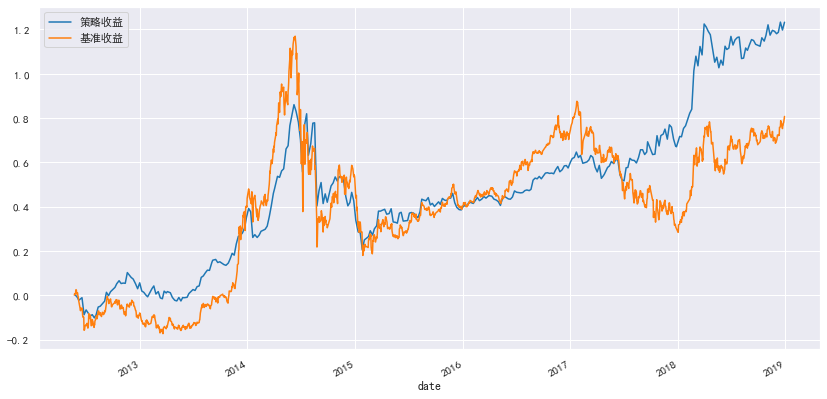

In [22]:
m.plot_cash()

---

# 盲测

In [23]:
x = get_data(CODE, '2019-12-01','2020-12-31')
x=combine_trade_func_fix(x)
m = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=combine_buy_price_func, sell_price_func=combine_sell_price_func)
m.stats()

245it [00:00, 1106.20it/s]


基准收益      0.3087
策略收益      0.1809
基准年化收益    0.3151
策略年化收益    0.1846
基准最大回撤   -0.1566
策略最大回撤   -0.1380
dtype: float64

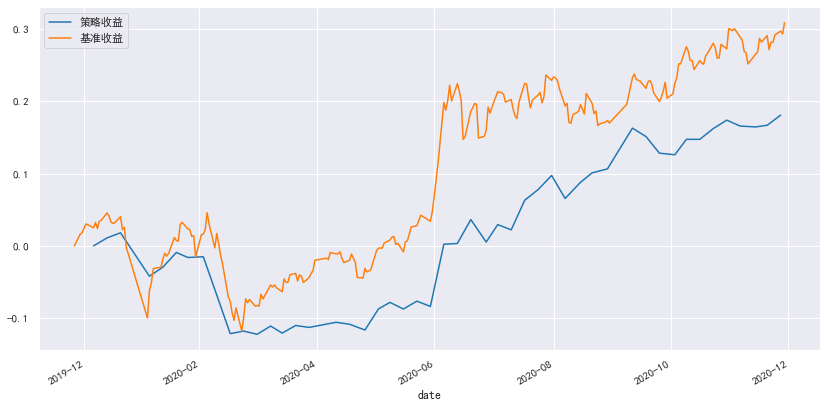

In [24]:
m.plot_cash()

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m.report())

剩余现金              11705.16
交易次数                    49
未结束交易次数                  0
未结束交易购买金额             0.00
盈利次数                    29
亏损次数                    20
盈利次数占比              59.18%
盈利(含交易费)次数              28
亏损(含交易费)次数              21
盈利(含交易费)次数占比        57.14%
盈利交易平均获利            181.41
亏损交易平均亏损           -163.11
盈利(含交易费)交易平均获利      187.70
亏损(含交易费)交易平均亏损     -155.10
盈亏总额               1998.60
手续费总额               293.44
手续费均值                 2.99
最大盈利%                9.68%
最大亏损%               -6.44%
最大(含交易费)盈利%          9.61%
最大(含交易费)亏损%         -6.49%
dtype: object


从盲测结果来看，貌似又没那么美好。应该还是之前过度适应造成的，计算周内效应时使用的数据和回测时使用的数据是同一批数据，所以造成了此问题。后面尝试使用前3年的数据来判断后一年的结果试试看。

Text(0.5, 1.0, '下跌市-日收盘相对开盘涨跌幅中位数')

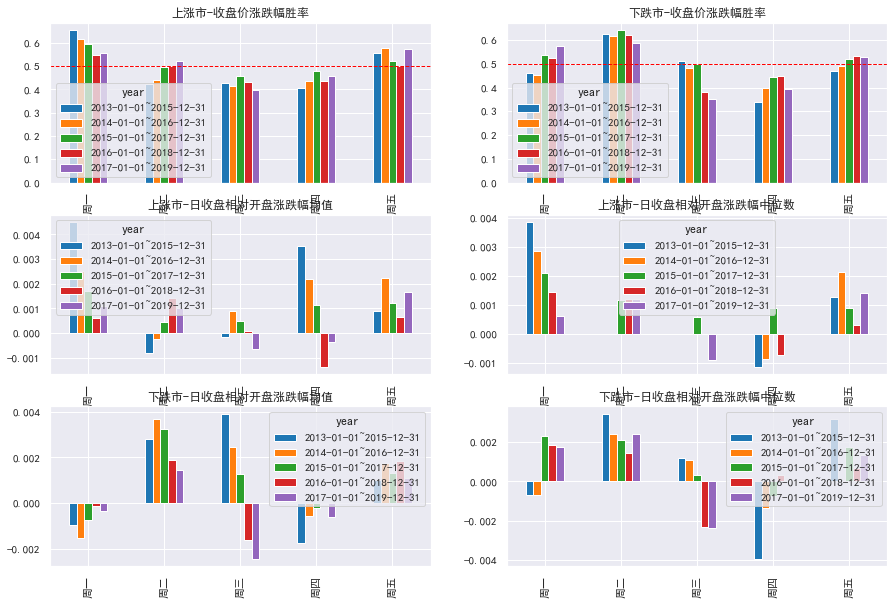

In [26]:
dfs_up=[]
dfs_down=[]
for i in range(2013,2018):
    start='{}-01-01'.format(i)
    end='{}-12-31'.format(i+2)
    data=get_data(CODE,start,end)
    df_up=get_desc(data[data['prev_up']==True]).T
    df_up['year']='{}~{}'.format(start,end)
    df_down=get_desc(data[data['prev_down']==True]).T
    df_down['year']='{}~{}'.format(start,end)
    dfs_up.append(df_up)
    dfs_down.append(df_down)
    
dfs_up=pd.concat(dfs_up)
dfs_down=pd.concat(dfs_down)

f = plt.figure(figsize=(15,10))
ax1 = f.add_subplot(321)
ax2 = f.add_subplot(322)
ax3 = f.add_subplot(323)
ax4 = f.add_subplot(324)
ax5 = f.add_subplot(325)
ax6 = f.add_subplot(326)

# 日收盘相对开盘涨跌幅均值','日收盘相对开盘涨跌幅中位数

dfs_up.loc['收盘价涨跌幅胜率'].set_index("year").T.plot(kind='bar',ax=ax1)
ax1.axhline(y=0.5,linewidth=1,ls='--', color='r')
ax1.set_title("上涨市-收盘价涨跌幅胜率")
dfs_down.loc['收盘价涨跌幅胜率'].set_index("year").T.plot(kind='bar',ax=ax2)
ax2.axhline(y=0.5,linewidth=1,ls='--', color='r')
ax2.set_title("下跌市-收盘价涨跌幅胜率")
dfs_up.loc['日收盘相对开盘涨跌幅均值'].set_index("year").T.plot(kind='bar',ax=ax3)
ax3.set_title("上涨市-日收盘相对开盘涨跌幅均值")
dfs_up.loc['日收盘相对开盘涨跌幅中位数'].set_index("year").T.plot(kind='bar',ax=ax4)
ax4.set_title("上涨市-日收盘相对开盘涨跌幅中位数")
dfs_down.loc['日收盘相对开盘涨跌幅均值'].set_index("year").T.plot(kind='bar',ax=ax5)
ax5.set_title("下跌市-日收盘相对开盘涨跌幅均值")
dfs_down.loc['日收盘相对开盘涨跌幅中位数'].set_index("year").T.plot(kind='bar',ax=ax6)
ax6.set_title("下跌市-日收盘相对开盘涨跌幅中位数")

从上图看来

* 上涨市时：周一获胜概率正在逐渐下降，而周二的获胜概率正在逐渐上升。以2017~2019年的测试结果来看，可以尝试在周一、周二、周五持有。以开盘价买入
* 下跌市时：同样周一、周二、周五三天的获胜概率均超过了50%

对比之前[盲测](#%E7%9B%B2%E6%B5%8B)的结果来说，收益率由`0.1809`提升至了`0.2155`(但是依然没有跑赢基准`0.3087`),最大回撤由`-0.1380`降低至`-0.1287`(基准`-0.1566`）。

---

# 循环回测

分别简单根据上图测试了自2015年至2020年的每年数据。发现一个有趣的现象，虽然正向收益的年份，收益率均不如基准，但是在负向收益的年份，却可以保持正向收益（这应该是因为我们区分了上涨市和下跌市的不同操作而做到的），并且所有年份中的策略最大回撤均低于基准最大回撤。

所以这中策略应该还算是一个可以备选的策略。

In [27]:
def bf_UP_014(data,**kwargs):
    """上涨市，并且下一个交易日是周一、周二、周五->买入"""
    data.loc[(data['prev_up']==True)&(data['nextday'].isin([0,1,4])),'buy']=1
    return data

def sf_UP_014(data,**kwargs):
    """上涨市，并且下一个交易日是周三、周四->卖出"""
    data.loc[(data['prev_up']==True)&(~data['nextday'].isin([0,1,4])),'sell']=1
    return data

def bf_UP_04(data,**kwargs):
    """上涨市，并且下一个交易日是周一、周二、周五->买入"""
    data.loc[(data['prev_up']==True)&(data['nextday'].isin([0,4])),'buy']=1
    return data

def sf_UP_04(data,**kwargs):
    """上涨市，并且下一个交易日是周三、周四->卖出"""
    data.loc[(data['prev_up']==True)&(~data['nextday'].isin([0,4])),'sell']=1
    return data

def bf_DOWN_0124(data,**kwargs):
    data.loc[(data['prev_down']==True)&(data['nextday'].isin([0,1,2,4])),'buy']=1
    return data

def sf_DOWN_0124(data,**kwargs):
    data.loc[(data['prev_down']==True)&(~data['nextday'].isin([0,1,2,4])),'sell']=1
    return data

def bf_DOWN_1(data,**kwargs):
    data.loc[(data['prev_down']==True)&(data['nextday'].isin([1])),'buy']=1
    return data

def sf_DOWN_1(data,**kwargs):
    data.loc[(data['prev_down']==True)&(~data['nextday'].isin([1])),'sell']=1
    return data

def bf_DOWN_12(data,**kwargs):
    data.loc[(data['prev_down']==True)&(data['nextday'].isin([1,2])),'buy']=1
    return data

def sf_DOWN_12(data,**kwargs):
    data.loc[(data['prev_down']==True)&(~data['nextday'].isin([1,2])),'sell']=1
    return data

def bf_DOWN_014(data,**kwargs):
    """下跌市，并且下一个交易日是周一、周二、周五->买入"""
    data.loc[(data['prev_down']==True)&(data['nextday'].isin([0,1,4])),'buy']=1
    return data

def sf_DOWN_014(data,**kwargs):
    """下跌市，卖出"""
    data.loc[(data['prev_down']==True)&(~data['nextday'].isin([0,1,4])),'sell']=1
    return data

def bpf_014(index, row, data):
    """无论上涨市还是下跌市，在周一，周二，周五均以开盘价买入"""
    if row['weekday'] in (0,1,4):
        return row['open']
    else:
        return row['close']

def spf_014(index, row, data):
    """无论上涨市还是下跌市，在周一，周二，周五均以收盘价卖出"""
    if row['weekday'] in (0,1,4):
        return row['close']
    else:
        return row['open']

x1 = get_data(CODE, '2019-12-01','2020-12-31')
x1=bf_UP_014(x1)
x1=bf_DOWN_014(x1)
x1=sf_UP_014(x1)
x1=sf_DOWN_014(x1)

x2 = get_data(CODE, '2018-12-01','2019-12-31')
x2=bf_UP_014(x2)
x2=bf_DOWN_014(x2)
x2=sf_UP_014(x2)
x2=sf_DOWN_014(x2)

x3 = get_data(CODE, '2017-12-01','2018-12-31')
x3=bf_UP_04(x3)
x3=bf_DOWN_0124(x3)
x3=sf_UP_04(x3)
x3=sf_DOWN_0124(x3)

x4 = get_data(CODE, '2016-12-01','2017-12-31')
x4=bf_UP_04(x4)
x4=bf_DOWN_1(x4)
x4=sf_UP_04(x4)
x4=sf_DOWN_1(x4)

x5 = get_data(CODE, '2015-12-01','2016-12-31')
x5=bf_UP_04(x5)
x5=bf_DOWN_12(x5)
x5=sf_UP_04(x5)
x5=sf_DOWN_12(x5)

every_year_df=pd.DataFrame({'2019-12-01~2020-12-31':backtest(x1, benchmark_pd=x1, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=bpf_014, sell_price_func=spf_014).stats(),
             '2018-12-01~2019-12-31':backtest(x2, benchmark_pd=x2, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=bpf_014, sell_price_func=spf_014).stats(),
             '2017-12-01~2018-12-31':backtest(x3, benchmark_pd=x3, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=bpf_014, sell_price_func=spf_014).stats(),
             '2016-12-01~2017-12-31':backtest(x4, benchmark_pd=x4, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=bpf_014, sell_price_func=spf_014).stats(),
             '2015-12-01~2016-12-31':backtest(x5, benchmark_pd=x5, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=bpf_014, sell_price_func=spf_014).stats()}).T

245it [00:00, 1123.57it/s]
244it [00:00, 1008.61it/s]
244it [00:00, 1054.12it/s]
246it [00:00, 1040.92it/s]
247it [00:00, 953.84it/s]


In [35]:
every_year_df.sort_index()[['基准收益','策略收益']].cumsum().join(every_year_df.sort_index()[['基准收益','策略收益','基准最大回撤','策略最大回撤']],lsuffix='cumsum')

,基准收益cumsum,策略收益cumsum,基准收益,策略收益,基准最大回撤,策略最大回撤
2015-12-01~2016-12-31,-0.0948,0.0674,-0.0948,0.0674,-0.2357,-0.0719
2016-12-01~2017-12-31,0.1424,0.1707,0.2372,0.1033,-0.0617,-0.0277
2017-12-01~2018-12-31,-0.0983,0.1981,-0.2407,0.0274,-0.3051,-0.0998
2018-12-01~2019-12-31,0.2910,0.5022,0.3893,0.3040,-0.1322,-0.0797
2019-12-01~2020-12-31,0.5998,0.7177,0.3087,0.2155,-0.1566,-0.1287
